<a href="https://colab.research.google.com/github/AhmedWael2000/brainTumorSegmentation/blob/main/brain_tumor_segmentation_RMI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import os
from glob import glob
import pandas as pd
import cv2
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.models import vgg16_bn
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [11]:
! kaggle datasets download -d mateuszbuda/lgg-mri-segmentation


Dataset URL: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation
License(s): CC-BY-NC-SA-4.0
 99% 706M/714M [00:08<00:00, 90.4MB/s]
100% 714M/714M [00:09<00:00, 82.4MB/s]


In [ ]:

!unzip /content/lgg-mri-segmentation.zip


In [ ]:
# function to create dataframe
def create_df(data_dir):
    images_paths = []
    masks_paths = glob(f'{data_dir}/*/*_mask*')

    for i in masks_paths:
        images_paths.append(i.replace('_mask', ''))

    df = pd.DataFrame(data= {'images_paths': images_paths, 'masks_paths': masks_paths})

    return df

# Function to split dataframe into train, valid, test
def split_df(df):
    # create train_df
    train_df, dummy_df = train_test_split(df, train_size= 0.8)

    # create valid_df and test_df
    valid_df, test_df = train_test_split(dummy_df, train_size= 0.5)

    return train_df, valid_df, test_df

In [ ]:
data_path = "/content/kaggle_3m"
df = create_df(data_path)
train_df, val_df, test_df = split_df(df)

In [ ]:
train_df.iloc[1]

images_paths    /content/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_...
masks_paths     /content/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_...
Name: 1405, dtype: object

In [ ]:
print('Train\t', train_df.shape, '\nVal\t', val_df.shape, '\nTest\t', test_df.shape)

Train	 (3143, 2) 
Val	 (393, 2) 
Test	 (393, 2)


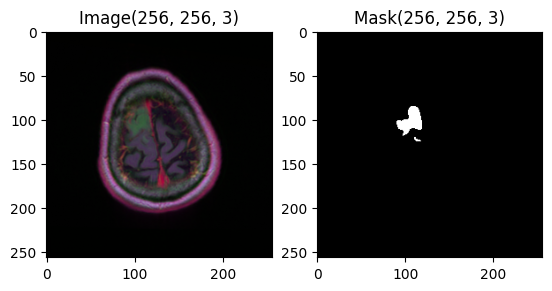

In [ ]:
image = cv2.imread(train_df.iloc[0, 0]) / 255.0
mask = cv2.imread(train_df.iloc[0, 1]) / 255.0
mask = np.where(mask>=0.5, 1., 0.)

plt.subplot(1,2,1)
plt.imshow(image)
plt.title('Image'+str(image.shape))
plt.subplot(1,2,2)
plt.imshow(mask)
plt.title('Mask'+str(mask.shape))
plt.show()


In [ ]:
class Brain_mri_dataset(torch.utils.data.Dataset):
    def __init__(self, dataframe  ,  transform = None ,  mask_transform= None):
        self.df = dataframe #pd.read_csv(annotations_file)
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self , idx):
        image = cv2.imread(self.df.iloc[idx, 0]) / 255.0
        mask = cv2.imread(self.df.iloc[idx, 1])  / 255.0
        mask = np.where(mask>=0.5, 1., 0.)
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

In [ ]:
transform_ = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256))
])

train_data = Brain_mri_dataset(train_df, transform = transform_ ,  mask_transform= transform_)
val_data = Brain_mri_dataset(val_df, transform = transform_ ,  mask_transform= transform_)
test_data = Brain_mri_dataset(test_df, transform = transform_ ,  mask_transform= transform_)

batch_size = 32

train_dataloader = DataLoader(train_data, batch_size = batch_size , shuffle = True)
val_dataloader = DataLoader(val_data, batch_size = batch_size , shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = batch_size , shuffle = True)

In [ ]:
print('Training batches\t', len(train_dataloader))
print('Validation batches\t', len(val_dataloader))
print('Test batches\t\t', len(test_dataloader))

Training batches	 99
Validation batches	 13
Test batches		 13


In [ ]:
img_sample, msk_sample = next(iter(val_dataloader))
print(img_sample.shape, '\t', img_sample.dtype)
print(msk_sample.shape, '\t', msk_sample.dtype)

torch.Size([32, 3, 256, 256]) 	 torch.float64
torch.Size([32, 3, 256, 256]) 	 torch.float64


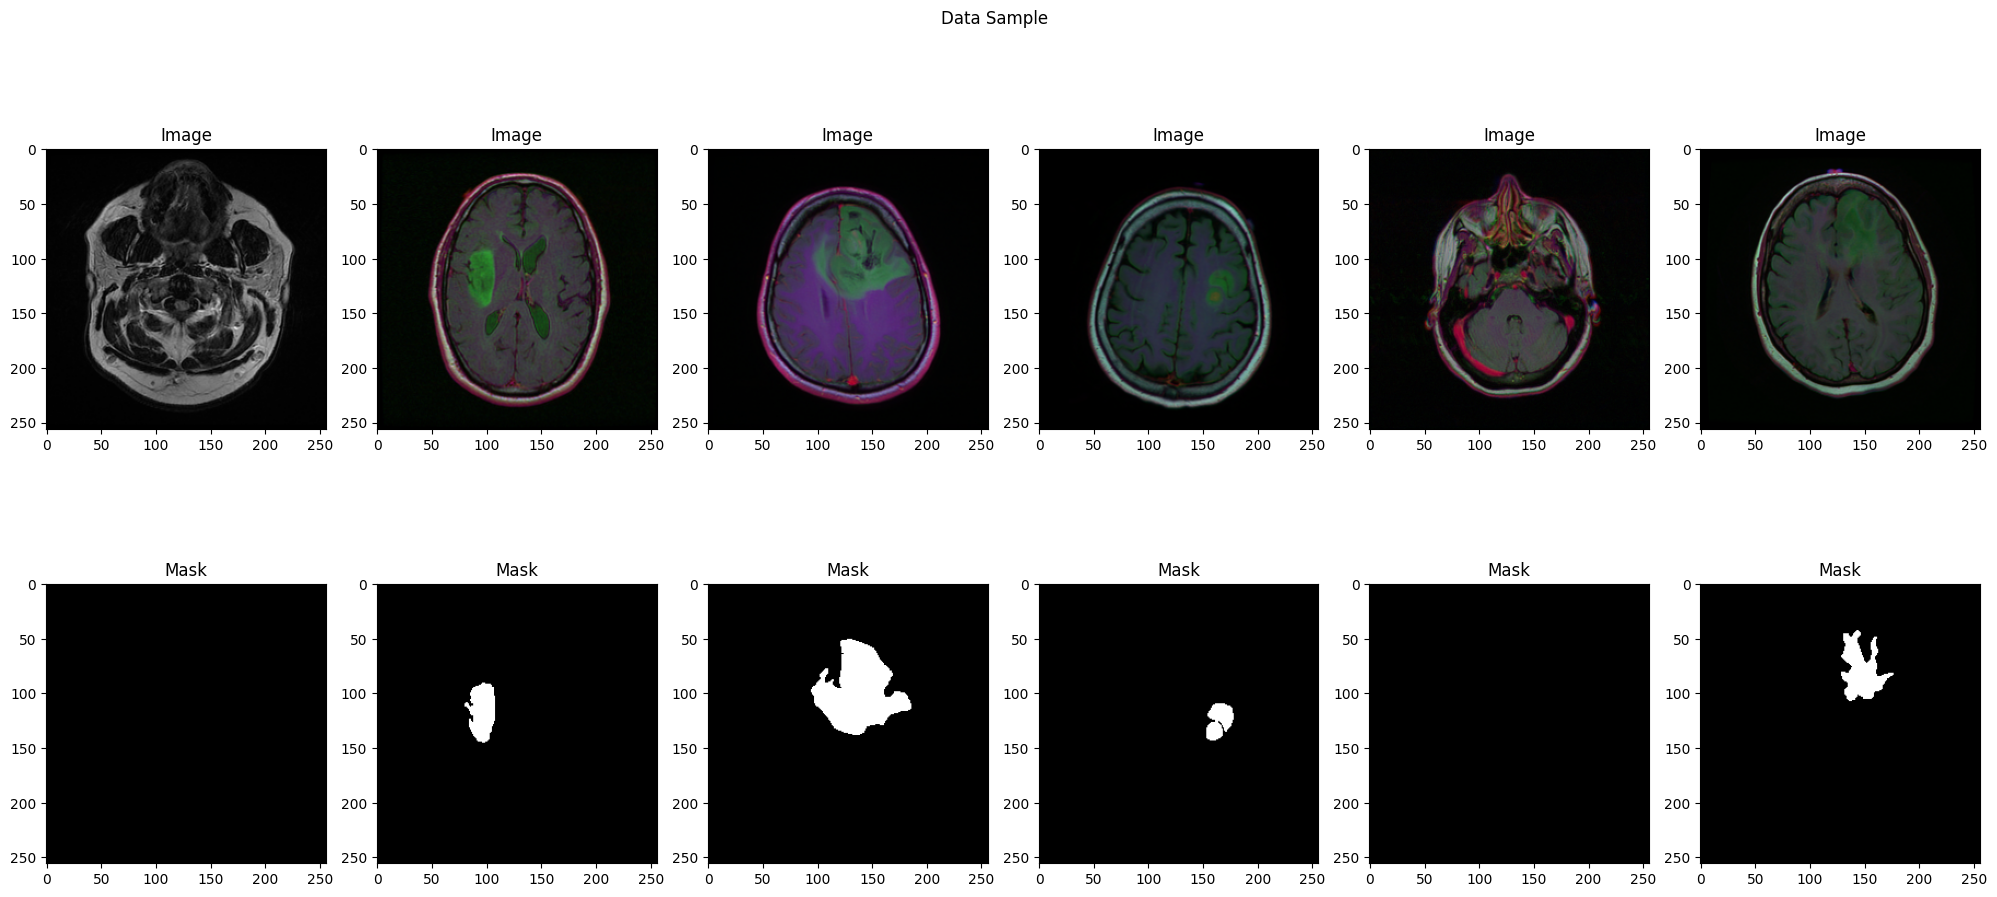

In [ ]:
fig, axs = plt.subplots(2, 6, figsize=(20, 10))
for i in range(6):
  axs[0, i].imshow(img_sample[i].permute(1,2,0))
  axs[0, i].set_title("Image")

  axs[1, i].imshow(msk_sample[i].permute(1,2,0))
  axs[1, i].set_title("Mask")
fig.suptitle('Data Sample')
fig.tight_layout()
fig.show()

In [ ]:
def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.Sigmoid()
    )

class UNet(nn.Module):
    def __init__(self, pretrained=True, out_channels=3):
        super().__init__()


        encoder = vgg16_bn(pretrained=pretrained).features
        self.block1 = nn.Sequential(*encoder[:6])
        self.block2 = nn.Sequential(*encoder[6:13])
        self.block3 = nn.Sequential(*encoder[13:20])
        self.block4 = nn.Sequential(*encoder[20:27])
        self.block5 = nn.Sequential(*encoder[27:34])
        self.bottleneck = nn.Sequential(*encoder[34:])

        for param in self.block1.parameters():
            param.requires_grad = False
        for param in self.block2.parameters():
            param.requires_grad = False
        for param in self.block3.parameters():
            param.requires_grad = False
        for param in self.block4.parameters():
            param.requires_grad = False
        for param in self.block5.parameters():
            param.requires_grad = False
        for param in self.bottleneck.parameters():
            param.requires_grad = False


        self.conv_bottleneck = conv(512, 1024)


        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = conv(512 + 512, 512)
        self.up_conv7 = up_conv(512, 256)
        self.conv7 = conv(256 + 512, 256)
        self.up_conv8 = up_conv(256, 128)
        self.conv8 = conv(128 + 256, 128)
        self.up_conv9 = up_conv(128, 64)
        self.conv9 = conv(64 + 128, 64)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = conv(32 + 64, 224)
        self.conv11 = nn.Conv2d(224, out_channels, kernel_size=1)


    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)


        bottleneck = self.bottleneck(block5)
        x = self.conv_bottleneck(bottleneck)


        x = self.up_conv6(x)
        x = torch.cat([x, block5], dim=1)
        x = self.conv6(x)


        x = self.up_conv7(x)
        x = torch.cat([x, block4], dim=1)
        x = self.conv7(x)


        x = self.up_conv8(x)
        x = torch.cat([x, block3], dim=1)
        x = self.conv8(x)


        x = self.up_conv9(x)
        x = torch.cat([x, block2], dim=1)
        x = self.conv9(x)


        x = self.up_conv10(x)
        x = torch.cat([x, block1], dim=1)
        x = self.conv10(x)


        x = self.conv11(x).float()

        x = torch.sigmoid(x)
        # x = torch.where(x>0.4, 1.0, 0.0)

        return x


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model = UNet().to(device)
model

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:05<00:00, 103MB/s] 


UNet(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (block2): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
  )
  (block3): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dil

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total parameters: {total_params}')
print(f'Trainable parameters: {trainable_params}')


Total parameters: 29478051
Trainable parameters: 14754915


In [ ]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth = 100
        num = targets.size(0)
        probs = torch.sigmoid(logits)
        m1 = probs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2).sum()

        return 1 - ((2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth))

In [ ]:
def IOU(y_true, y_pred, smooth=100):
    intersection = (y_true * y_pred).sum()
    sum = (y_true + y_pred).sum()
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou

In [ ]:
learning_rate = 0.005

criterion = nn.MSELoss()
optimizer = optim.Adam(
    model.parameters(),
    lr=learning_rate)
# epochs=10

train_loss=[]
val_loss = []
trainIOU = []
valIOU = []

In [ ]:
epochs=10
learning_rate = 0.005

In [ ]:


for epoch in range(epochs):

  total_train_loss=0
  total_val_loss=0
  # training mode
  model.train()
  total_train_iou = 0.0
  for img,label in train_dataloader:
    # print(img.shape)
    img, label =img.to(device).float(),label.to(device).float()
    optimizer.zero_grad()
    pred = model(img)
    loss = criterion(pred,label)
    total_train_loss+=loss.item()
    iou = IOU(label, pred)
    total_train_iou += iou.item()
    loss.backward()
    optimizer.step()
  train_iou = total_train_iou / (len(train_dataloader)+1)
  trainIOU.append(train_iou)
  train_loss.append(total_train_loss/(len(train_dataloader)+1))

  # validation mode
  model.eval()
  total_val_iou = 0.0
  with torch.no_grad():
    for image,label in val_dataloader:
      image, label = image.to(device).float(), label.to(device).float()
      pred = model(image)
      loss = criterion(pred, label)
      total_val_loss += loss.item()
      iou = IOU(label, pred)
      total_val_iou += iou.item()

    val_iou = total_val_iou / (len(val_dataloader) + 1)
    valIOU.append(val_iou)
    total_val_loss = total_val_loss / (len(val_dataloader) + 1)
    val_loss.append(total_val_loss)

  print('Epoch: {}/{},\tTrain Loss: {:.4f},\tTrain IOU: {:.4f},\tVal Loss: {:.4f},\tVal IOU: {:.4f}'.format(epoch+1, epochs, total_train_loss, train_iou, total_val_loss, val_iou))

  # return train_loss, val_loss, val_acc

Epoch: 1/10,	Train Loss: 0.1001,	Train IOU: 0.7255,	Val Loss: 0.0025,	Val IOU: 0.5697
Epoch: 2/10,	Train Loss: 0.0919,	Train IOU: 0.7354,	Val Loss: 0.0028,	Val IOU: 0.5153
Epoch: 3/10,	Train Loss: 0.0885,	Train IOU: 0.7445,	Val Loss: 0.0018,	Val IOU: 0.6574
Epoch: 4/10,	Train Loss: 0.0820,	Train IOU: 0.7594,	Val Loss: 0.0042,	Val IOU: 0.4723
Epoch: 5/10,	Train Loss: 0.0760,	Train IOU: 0.7683,	Val Loss: 0.0031,	Val IOU: 0.4961
Epoch: 6/10,	Train Loss: 0.0784,	Train IOU: 0.7629,	Val Loss: 0.0019,	Val IOU: 0.6436
Epoch: 7/10,	Train Loss: 0.0722,	Train IOU: 0.7845,	Val Loss: 0.0022,	Val IOU: 0.6115
Epoch: 8/10,	Train Loss: 0.0678,	Train IOU: 0.7981,	Val Loss: 0.0017,	Val IOU: 0.6543
Epoch: 9/10,	Train Loss: 0.0607,	Train IOU: 0.8165,	Val Loss: 0.0022,	Val IOU: 0.5939
Epoch: 10/10,	Train Loss: 0.0588,	Train IOU: 0.8233,	Val Loss: 0.0025,	Val IOU: 0.5955


In [ ]:
torch.save(model.state_dict(), '/root/brainTumor.pt')

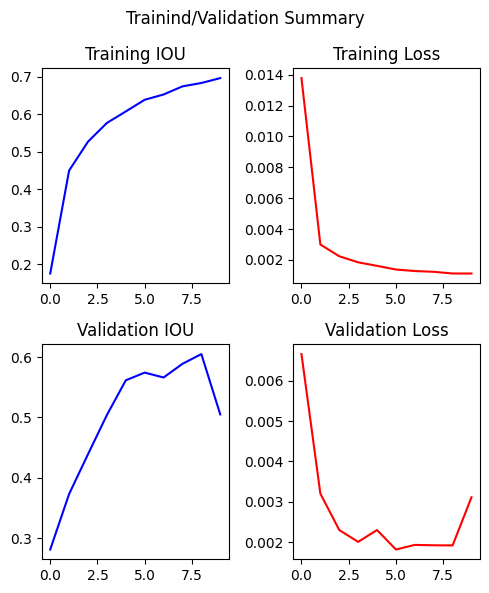

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(5, 6))

axs[0, 0].plot(trainIOU, c='blue')
axs[0, 0].set_title("Training IOU")

axs[0, 1].plot(train_loss, c='red')
axs[0, 1].set_title("Training Loss")

axs[1, 0].plot(valIOU, c='blue')
axs[1, 0].set_title("Validation IOU")

axs[1, 1].plot(val_loss, c='red')
axs[1, 1].set_title("Validation Loss")

fig.suptitle('Trainind/Validation Summary')
fig.tight_layout()
fig.show()


In [ ]:
def show_sample(data,n=2):
  imgs, true_masks = data
  results = model(imgs.to(device).float()).cpu()
  results = torch.where(results >= 0.6, 1.0, 0.0)
#   results = torch.tensor(results)

  fig, axs = plt.subplots(3, n, figsize=(n*3, 9))
  for i in range(n):
      axs[0, i].imshow(imgs[i].permute(1,2,0))
      axs[0, i].set_title("Input Image")

      axs[1, i].imshow(results[i].permute(1,2,0))
      axs[1, i].set_title("Predected Mask")

      axs[2, i].imshow(true_masks[i].permute(1,2,0))
      axs[2, i].set_title("True Mask")
  fig.suptitle('Results Sample')
  fig.tight_layout()
  fig.show()


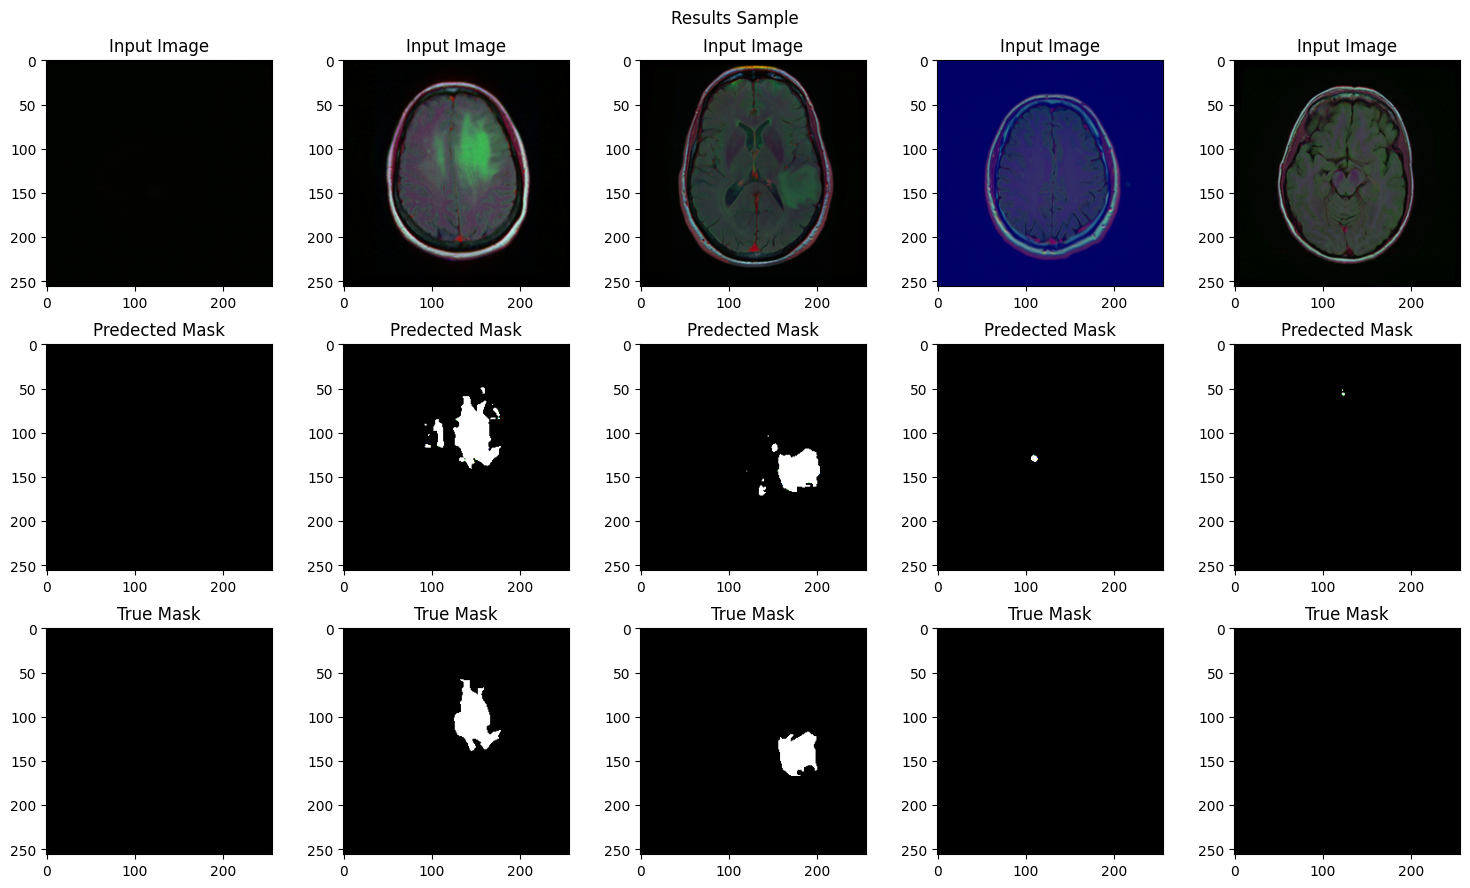

In [ ]:
show_sample(next(iter(test_dataloader)), 5)